### Cross time, cross condition decoding for selected features, split by pref/notpref

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

### Cross cond pref/not pref

In [3]:
args = argparse.Namespace(
    **SingleSelectedFeatureCrossCondConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.beh_filters = {"PreferredChosen": True}
args.use_v2_pseudo = True

cross_res = io_utils.read_selected_features_cross_cond(args, FEATURES, ["pref", "not_pref"])

args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.beh_filters = {"PreferredChosen": True}
args.use_v2_pseudo = True

res = io_utils.read_selected_features(args, FEATURES, conds=["pref", "not_pref"])

all_res = pd.concat((res, cross_res))

Text(0.5, 1.0, 'Not Preferred')

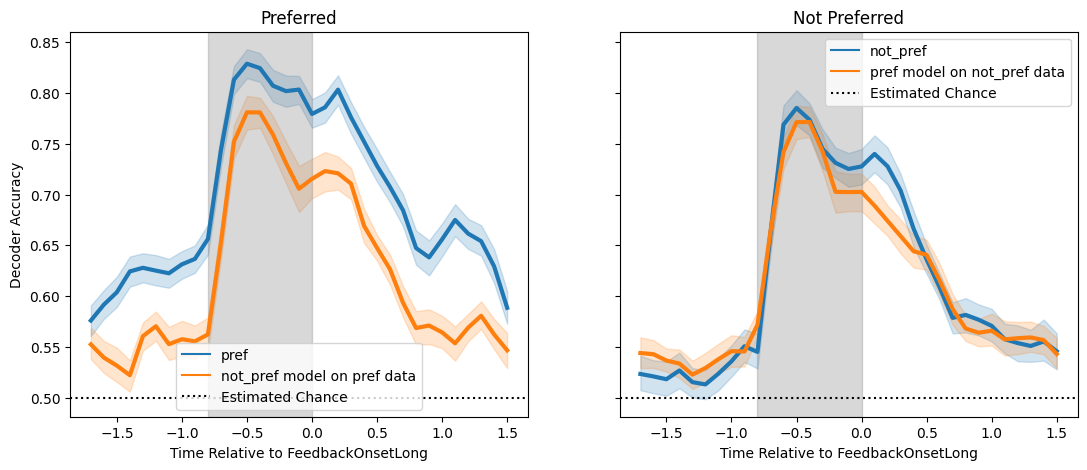

In [4]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

pref_res = all_res[all_res.condition.isin(["pref", "not_pref model on pref data"])]
visualization_utils.visualize_preferred_beliefs(args, pref_res, ax0)
ax0.set_title("Preferred")


not_pref_res = all_res[all_res.condition.isin(["not_pref", "pref model on not_pref data"])]
visualization_utils.visualize_preferred_beliefs(args, not_pref_res, ax1)
ax1.set_title("Not Preferred")


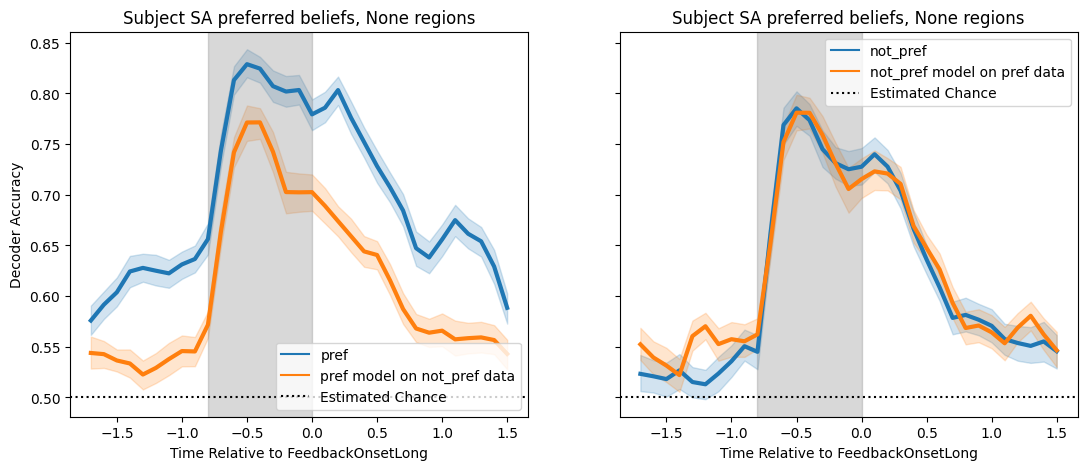

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

res = all_res[all_res.condition.isin(["pref", "pref model on not_pref data"])]
visualization_utils.visualize_preferred_beliefs(args, res, ax0)

res = all_res[all_res.condition.isin(["not_pref", "not_pref model on pref data"])]
visualization_utils.visualize_preferred_beliefs(args, res, ax1)

### Cross time, pref, not pref

<Axes: xlabel='TestTime', ylabel='TrainTime'>

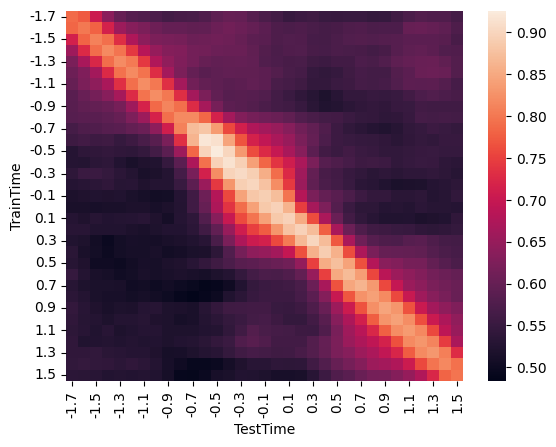

In [13]:
args = argparse.Namespace(
    **SingleSelectedFeatureCrossCondConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.beh_filters = {"PreferredChosen": True}

res = io_utils.read_selected_features_cross_time(args, FEATURES, "pref", avg=True)
pivoted = res.pivot(index="TrainTime", columns="TestTime", values="Accuracy")
sns.heatmap(pivoted)

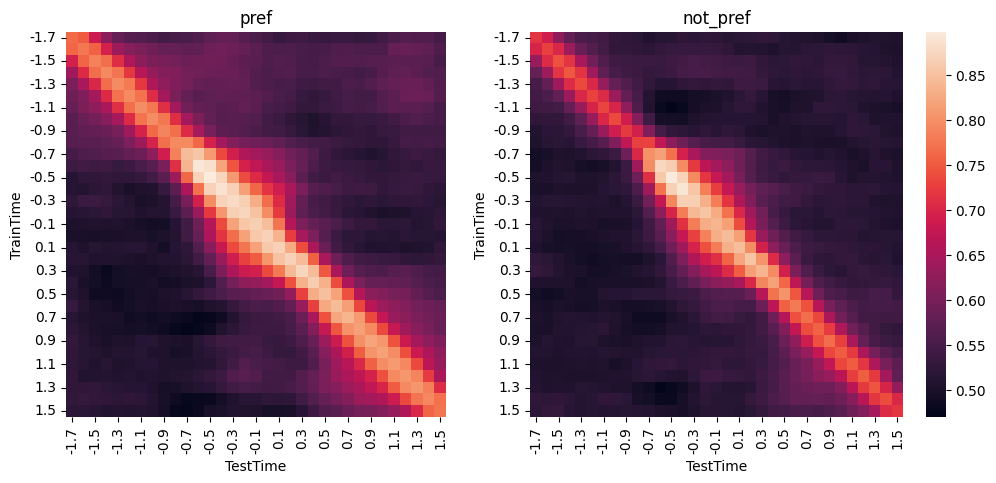

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[5.7, 7])
for i, cond in enumerate(["pref", "not_pref"]):
    args = argparse.Namespace(
        **SingleSelectedFeatureConfigs()._asdict()
    )
    args.trial_event = "FeedbackOnsetLong"
    args.beh_filters = {"PreferredChosen": True}
    res = io_utils.read_selected_features_cross_time(args, FEATURES, cond, avg=True)
    pivoted = res.pivot(index="TrainTime", columns="TestTime", values="Accuracy")
    sns.heatmap(pivoted, ax=axs[i], cbar=(i == 1))
    axs[i].set_title(cond)

In [30]:
shuffles = io_utils.read_selected_features(args, FEATURES, ["chosen", "pref", "not_pref"])
shuffle_means = shuffles[shuffles.condition.isin(["chosen_shuffle", "pref_shuffle", "not_pref_shuffle"])].groupby(["Time", "condition"]).Accuracy.mean().reset_index(name="ShuffleAccuracy")

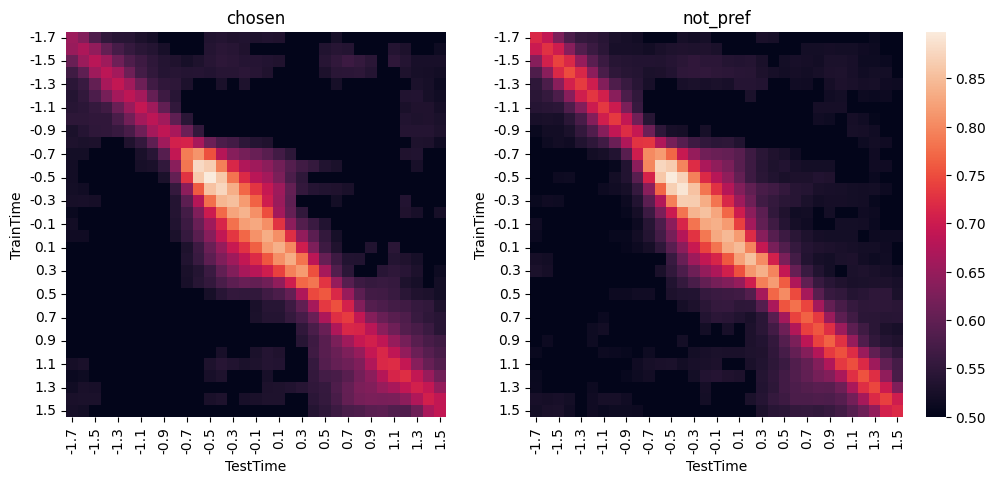

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[5.7, 7])
for i, cond in enumerate(["chosen", "not_pref"]):
    args = argparse.Namespace(
        **SingleSelectedFeatureConfigs()._asdict()
    )
    args.trial_event = "FeedbackOnsetLong"
    args.beh_filters = {"PreferredChosen": True}
    res = io_utils.read_selected_features_cross_time(args, FEATURES, cond, avg=True)
    res = pd.merge(res, shuffle_means[shuffle_means.condition == f"{cond}_shuffle"], left_on="TestTime", right_on="Time")
    res["Accuracy"] = res.apply(lambda x: 0.5 if x.Accuracy < x.ShuffleAccuracy else x.Accuracy, axis=1)

    pivoted = res.pivot(index="TrainTime", columns="TestTime", values="Accuracy")
    sns.heatmap(pivoted, ax=axs[i], cbar=(i == 1))
    axs[i].set_title(cond)